In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 
import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [109]:
common_years = np.arange(2005,2017)

#Get information from the shapefile
shape_file = '/Users/francesco/Desktop/squares.shp.gpkg'

ids = []
boundaries = []

# Open and extract boundaries
with fiona.open(shape_file, "r") as shapefile:
    for feature in shapefile:
        ids.append(int(feature['id'])) #id is registered as a string in the geometry file
        polygon = shape(feature['geometry'])
        bounds = polygon.bounds
        boundaries.append(bounds)

# Create a DataFrame with the information retrieved from the previous block
df = pd.DataFrame({'boundaries': boundaries}, index=ids)

# Sort the dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)



In [110]:
#Load the masks

cnn_dataset_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/'

ice_mask = np.load(cnn_dataset_directory + 'ice_mask.npy', allow_pickle=True)
land_mask = np.load(cnn_dataset_directory + 'land_mask.npy', allow_pickle=True)
sea_mask = np.load(cnn_dataset_directory + 'sea_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(cnn_dataset_directory + 'grounded_ice_mask.npy', allow_pickle=True)
boarders_mask = np.load(cnn_dataset_directory + 'boarders.npy', allow_pickle=True)

ice_mask = pd.DataFrame(ice_mask, index=df.index, columns=common_years)
land_mask = pd.DataFrame(land_mask, index=df.index, columns=common_years)
sea_mask = pd.DataFrame(sea_mask, index=df.index, columns=common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index=df.index, columns=common_years)
boarders_mask = pd.DataFrame(boarders_mask, index=df.index, columns=common_years)


In [111]:
#MULTI YEAR VELOCITY

velocity_multy_years_x_path = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_X.tif'
velocity_multy_years_y_path = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_Y.tif'

#dataset
velocity_multy_years_x =pd.DataFrame(index = df.index, columns = ['image'])
velocity_multy_years_y =pd.DataFrame(index = df.index, columns = ['image'])

#Extract the velocity data from the multi year dataset
for id in df.index:

        with rasterio.open(velocity_multy_years_x_path, crs = 'EPSG:3031') as src:
                xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']
                window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
                velocity_multy_years_x.loc[id, 'image'] = src.read(1, window=window)

        with rasterio.open(velocity_multy_years_y_path, crs = 'EPSG:3031') as src:
                xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']
                window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
                velocity_multy_years_y.loc[id,'image'] = src.read(1, window=window)


Total nan pixels:  529462
Not a NaN pixels:  519114


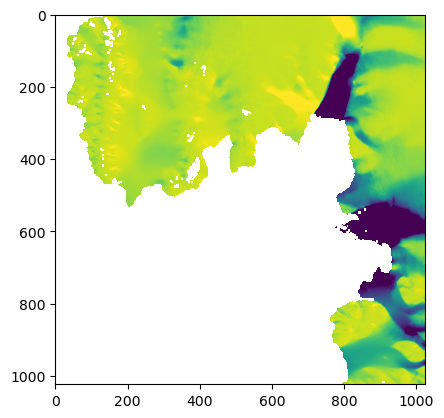

In [112]:
#multi year velocity
x = velocity_multy_years_x.loc[1, 'image']
x[x == 0] = np.nan
plt.imshow(x, cmap='viridis', vmin = -1000, vmax = 100)

#count the numebr of nan in velocity_multy_years_x.loc[1, 'image']
total_nan_pixels = np.sum(np.isnan(velocity_multy_years_x.loc[1, 'image']))
not_a_nan_pixels = np.sum(~np.isnan(velocity_multy_years_x.loc[1, 'image']))

print('Total nan pixels: ', total_nan_pixels)
print('Not a NaN pixels: ', not_a_nan_pixels)

In [113]:
#EXTRACTING SINGLE YEAR VELOCITY

list_x = []
list_y = []

#Velocity
velocity_x_tif = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_tif = pd.DataFrame(index = df.index, columns = common_years)

common_years = np.arange(2005,2017,1)

#FILE LIST (change in cluster)
for i in common_years:
    list_x.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VX.tif")
    list_y.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VY.tif")

#calculate the velocity for each year, for each region

for name_x, name_y, year in zip(list_x, list_y, common_years): #for each year

    for id in df.index: #for each region

        xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']

        with rasterio.open(name_x, crs = 'EPSG:3031') as src:
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image_x = src.read(1, window=window)

            #Exclude the 0.01 and 99.99 percentile
            values = np.nanpercentile(image_x.ravel(), [0.05, 99.95])
            image_x[image_x < values[0]] = np.nan
            image_x[image_x > values[1]] = np.nan

            #set to nan all the 0 values
            image_x[image_x == 0] = np.nan
            velocity_x_tif.loc[id, year] = image_x

        with rasterio.open(name_y, crs = 'EPSG:3031') as src:
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image_y = src.read(1, window=window)

            #Exclude the 0.05 and 99.95 percentile
            values = np.nanpercentile(image_y.ravel(), [0.05, 99.95])
            image_y[image_y < values[0]] = np.nan
            image_y[image_y > values[1]] = np.nan

            #set to nan all the 0 values
            image_y[image_y == 0] = np.nan
            velocity_y_tif.loc[id, year] = image_y

        

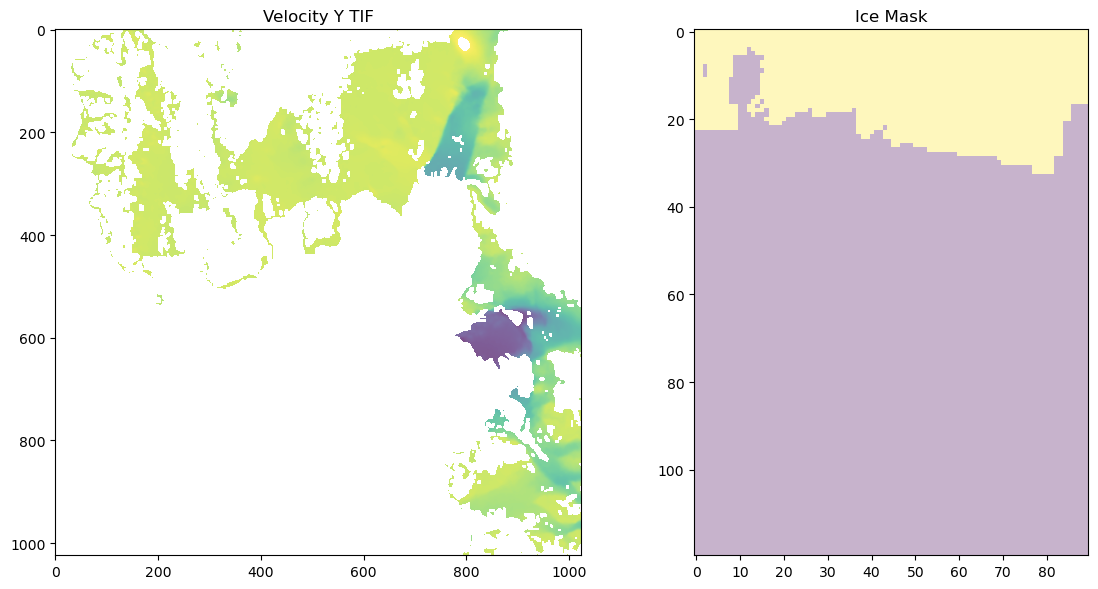

In [114]:
i =1
year = 2011
prova_2 = velocity_x_tif.loc[i, year]

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot the first image (velocity_y_tif)
plt.subplot(1, 2, 1)
plt.imshow(prova_2, cmap='viridis', alpha=0.7)
plt.title('Velocity Y TIF')

# Plot the second image (~sea_mask)
plt.subplot(1, 2, 2)
plt.imshow(ice_mask.loc[i, year][280:400,700:790], cmap='viridis', alpha=0.3)
plt.title('Ice Mask')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [115]:
#Smoothing and thresholding

from silx.image.medianfilter import medfilt2d

velocity_x_tif_smoothed = velocity_x_tif.copy()
velocity_y_tif_smoothed = velocity_y_tif.copy()

kernel_size = 4
threshold = 50

for id in df.index:
    for year in common_years:

        #smothering
        vx_tmp_smoothed = medfilt2d(velocity_x_tif_smoothed.loc[id, year], kernel_size)
        vy_tmp_smoothed = medfilt2d(velocity_y_tif_smoothed.loc[id, year], kernel_size)

        #thresholding
        velocity_x_tif_smoothed.loc[id, year][abs(velocity_x_tif_smoothed.loc[id, year] - vx_tmp_smoothed) > threshold] = np.nan
        velocity_y_tif_smoothed.loc[id, year][abs(velocity_y_tif_smoothed.loc[id, year] - vy_tmp_smoothed) > threshold] = np.nan


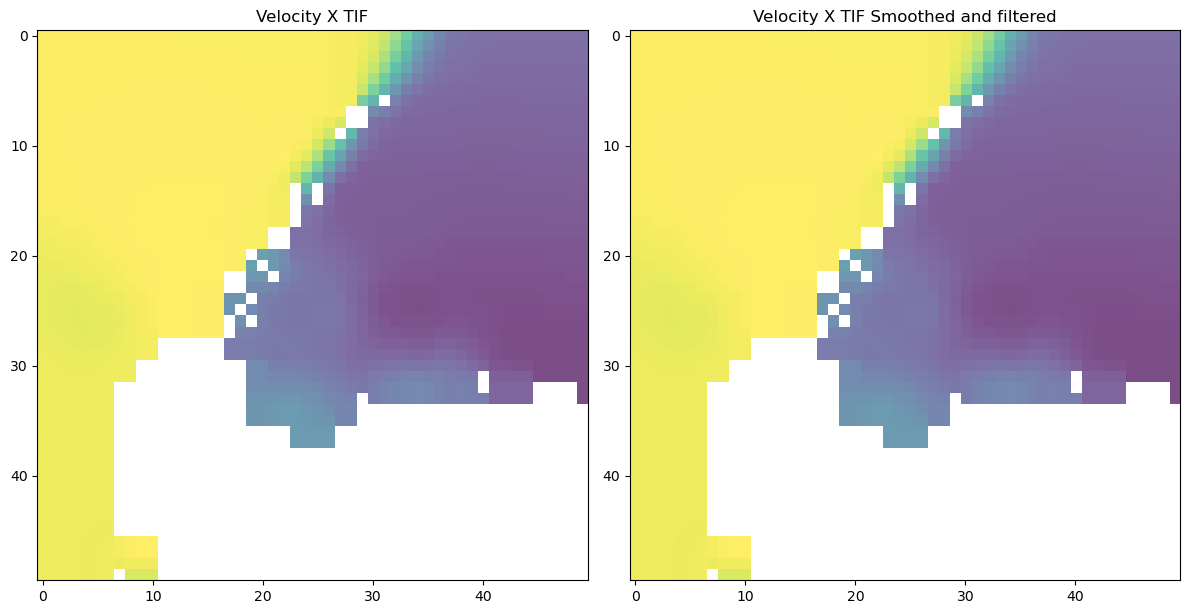

In [116]:
#plot both [250:300, 700:750] for Pine Island
year = 2013
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(velocity_x_tif.loc[1, year][250:300, 700:750], cmap='viridis', alpha=0.7)
plt.title('Velocity X TIF')

plt.subplot(1, 2, 2)
plt.imshow(velocity_x_tif_smoothed.loc[1, year][250:300, 700:750], cmap='viridis', alpha=0.7)
plt.title('Velocity X TIF Smoothed and filtered')

plt.tight_layout()
plt.show()

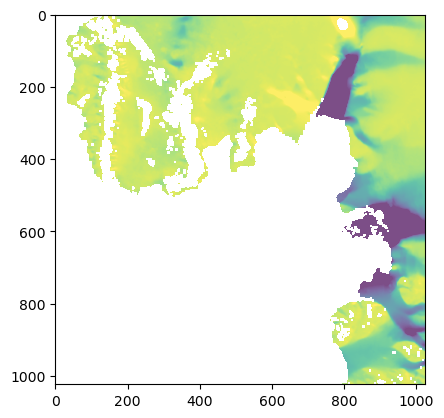

In [10]:
plt.imshow(velocity_x_tif_smoothed.loc[1, 2013], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)



<font size="5">Calculate the coverage ratio for each region and each year for the not floating ice</font>

In [11]:
#Now calculate the coverage ratio for each region.

coverage_no_nan_v_x_grounded = pd.DataFrame(index = df.index, columns = common_years)
coverage_no_nan_v_y_grounded = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #This takes the number of the NOT A NAN nan pixels in the region which is not sea,
        #divided by the total number of pixels which are not sea.

        #mask_grounded = np.logical_or(grounded_ice_mask.loc[id, year], land_mask.loc[id,year])
        mask_grounded = ~sea_mask.loc[id, year] #NEW VERSION

        coverage_no_nan_v_x_grounded.loc[id, year] = np.sum(~np.isnan(velocity_x_tif_smoothed.loc[id, year][mask_grounded])) / np.sum(mask_grounded)
        coverage_no_nan_v_y_grounded.loc[id, year] = np.sum(~np.isnan(velocity_y_tif_smoothed.loc[id, year][mask_grounded])) / np.sum(mask_grounded)


NO, IS DIFFERENT!
Here i calculate the rescaling ratio: EVERYTHING WILL NEED TO BE REDONE IN Y
- If coverage < 0.3 : take multi year without rescaling
- If 0.3 < coverage < 0.70: rescale the multi year
- If coverage > 0.70 interpolate

In [12]:
coverage_no_nan_v_x_grounded

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.457929,0.325308,0.719449,0.791665,0.576205,0.710896,0.478989,0.275146,0.913964,0.947315,0.767209,0.925112


In [13]:
#Now we look at the coverage and according to this we intepolate or not (5 mins per region)

from skimage.restoration import inpaint

interpo_x = pd.DataFrame(index = df.index, columns = common_years)

threshold_interpolation = 0.70

for id in df.index:
    for year in common_years:

        print(year)

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:

            mask_nan = np.isnan(velocity_x_tif_smoothed.loc[id, year])
            interpo_x.loc[id, year] = inpaint.inpaint_biharmonic(velocity_x_tif_smoothed.loc[id, year], mask_nan)
            interpo_x.loc[id, year][sea_mask.loc[id, year]] = np.nan


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [14]:
#Check for nan values

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_y_grounded.loc[id, year]  > threshold_interpolation:

            no_sea = ~sea_mask.loc[id, year]
            count_nan = np.sum(np.isnan(interpo_x.loc[id, year][no_sea]))
            print('Region: ', id, 'Year: ', year, 'Count nan: ', count_nan)

Region:  1 Year:  2007 Count nan:  0
Region:  1 Year:  2008 Count nan:  0
Region:  1 Year:  2010 Count nan:  0
Region:  1 Year:  2013 Count nan:  0
Region:  1 Year:  2014 Count nan:  0
Region:  1 Year:  2015 Count nan:  0
Region:  1 Year:  2016 Count nan:  0


In [15]:
#here we Calcualtate the ratios

ratios = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:
            ratios.loc[id, year] = interpo_x.loc[id, year] / velocity_multy_years_x.loc[id, 'image']

        else:    
            ratios.loc[id, year] = velocity_x_tif_smoothed.loc[id, year] / velocity_multy_years_x.loc[id, 'image']

#Now I set to 0 all the values which are not in the see but nan. 
#Because in the multi year velocity we have 0 values not in the sea,
#and the ratio is ofcourse impossible to calculate
            
for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:
  
            mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios.loc[id, year]))
            ratios.loc[id, year][mask_nan_and_not_sea] = 0
        

In [16]:
#Check for nan values in the ratio dataset in the no_sea_region

for id in df.index:
    for year in common_years:

        no_sea = ~sea_mask.loc[id, year]
        count_nan = np.sum(np.isnan(ratios.loc[id, year][no_sea]))
        print('Region: ', id, 'Year: ', year, 'Count nan: ', count_nan)

Region:  1 Year:  2005 Count nan:  291362
Region:  1 Year:  2006 Count nan:  363636
Region:  1 Year:  2007 Count nan:  0
Region:  1 Year:  2008 Count nan:  0
Region:  1 Year:  2009 Count nan:  229355
Region:  1 Year:  2010 Count nan:  0
Region:  1 Year:  2011 Count nan:  279076
Region:  1 Year:  2012 Count nan:  381707
Region:  1 Year:  2013 Count nan:  0
Region:  1 Year:  2014 Count nan:  0
Region:  1 Year:  2015 Count nan:  0
Region:  1 Year:  2016 Count nan:  0


In [17]:
#looking at some values to understand if later i reshaped well. Is working
for id in df.index:
    for year in common_years:

        print(ratios.loc[id, year][10,162])

nan
nan
0.5898197
0.92486155
nan
0.35123974
nan
nan
0.4103292
1.5609227
0.09327747
3.0575888


From Here on we will do the inteporlation pixel by pixel

In [18]:
#Reshaping the data
#the array indeces are (ice shelf, pixel, time)

raveled_vector = np.zeros((len(df.index),len(ratios.loc[id, year].ravel()), len(common_years))) 

index = 0

for id in df.index:
    
    time = 0

    for year in common_years:

        matrix = ratios.loc[id, year]

        array_raveled = matrix.ravel()

        raveled_vector[index, :,time] = array_raveled

        time = time + 1

    index = index + 1


In [19]:
mask_where_nan = np.isnan(raveled_vector) #correct

In [20]:
#Function to make the interpolation

def interpolation_excluding_extreames(A):

    A = np.array(A)

    x = np.interp(np.arange(len(A)), 
            np.arange(len(A))[np.isnan(A) == False], 
            A[np.isnan(A) == False])

    if np.isnan(A[0]) == True:
        x[0] = A[0]
        if np.isnan(A[1]) == True:
            x[1] = A[1]
            if np.isnan(A[2]) == True:
                x[2] = A[2]
                if np.isnan(A[3]) == True:
                    x[3] = A[3]

    if np.isnan(A[-1]) == True:
        x[-1] = A[-1]
        if np.isnan(A[-2]) == True:
            x[-2] = A[-2]
            if np.isnan(A[-3]) == True:
                x[-3] = A[-3]
                if np.isnan(A[-4]) == True:
                    x[-4] = A[-4]

    return x



In [21]:
def fill_fist_values(A):

    A = np.array(A)

    for i in range(len(A)):

        if np.isnan(A[i]) == False:
            A[:i] = A[i]
            break

    return A

In [22]:
#Example
x = [5,np.nan,3,4,5.5,np.nan,np.nan,np.nan,10,10,np.nan,16,13,14,15]

y = fill_fist_values(x)

print(y)

[ 5.   nan  3.   4.   5.5  nan  nan  nan 10.  10.   nan 16.  13.  14.
 15. ]


In [23]:
#step by step interpolation 

for i in range(len(df.index)): #for each region
   for j in range(len(ratios.loc[id, year].ravel())): #for each pixel of the region

      #take the values of the pixel
      y = raveled_vector[i, j, :] #here I am taking the ratio time serie for each pixel

      #If the value is all nan, skip to the next pixel
      if np.isnan(y).all() == True:
          continue

      #interpolate the nan values as the average of the two closest values
      y = interpolation_excluding_extreames(y)

      y = fill_fist_values(y)

      raveled_vector[i, j, :] = y

(2004.0, 2017.0)

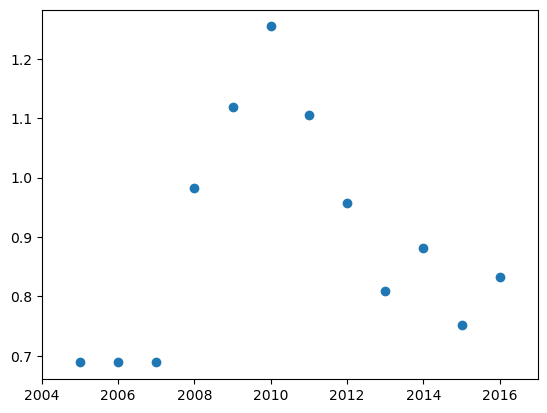

In [24]:
plt.scatter(common_years,raveled_vector[0, 455, :])
#Set axis bounds
plt.xlim(2004,2017)

In [25]:
# #Check if i removed all the nan values
# for i in range(len(df.index)):
#     for j in range(len(ratios.loc[id, year].ravel())):

#         if np.isnan(raveled_vector[i, j, :]).any() == True:
#             print('Region: ', i, 'Pixel: ', j)


In [26]:
#now we perform the linear regression for each pixel (2 mins maximum)

#linear_coeffs = np.zeros((len(df.index),len(ratios.loc[id, year].ravel()), 2))

# for i in range(len(df.index)): #for each region
#     for j in range(len(ratios.loc[id, year].ravel())): #for each pixel of the region

#         #take the values of the pixel
#         y = raveled_vector[i, j, :] #here I am taking the ratio time serie for each pixel
#         x = common_years

#         #exclude the nan values
#         mask = ~np.isnan(y)
#         y = y[mask]
#         x = x[mask]

#         #perform the linear regression
#         A = np.vstack([x, np.ones(len(x))]).T
#         m, c = np.linalg.lstsq(A, y, rcond=None)[0] #m is linear cooefficint, c is the constant

#         linear_coeffs[i, j, 0] = m
#         linear_coeffs[i, j, 1] = c

#substitute the nan values with the linear regression #RUN ONLY ONCE

# for i in range(len(df.index)):
#     for j in range(len(ratios.loc[id, year].ravel())):

#         mask = np.isnan(raveled_vector[i, j, :])
#         raveled_vector[i, j, mask] = linear_coeffs[i, j, 0] * common_years[mask] + linear_coeffs[i, j, 1]


In [27]:
#Re organising the interpolated ratio dataset

interpolated_ratios = pd.DataFrame(index = df.index, columns = common_years)

index_raveled = 0

for id in df.index:

    time = 0

    for year in common_years:

        matrix = raveled_vector[index_raveled, :, time].reshape(velocity_multy_years_x.loc[id, 'image'].shape)
        interpolated_ratios.loc[id, year] = matrix
        time = time + 1

    index_raveled = index_raveled + 1


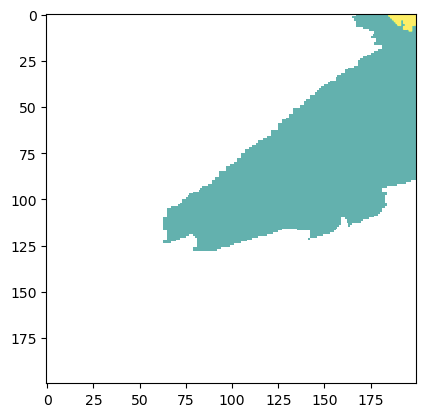

In [28]:
plt.imshow(interpolated_ratios.loc[1, 2007][600:800,600:800], cmap='viridis', alpha=0.7, vmin=-1, vmax=1)


In [97]:
#re-creating the velocity dataset, with holes

velocity_multi_and_single = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we just use the inteporlated images, where the coverage is good
        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:
            velocity_multi_and_single.loc[id, year] = interpo_x.loc[id, year]
            
        else:
            velocity_multi_and_single.loc[id, year] = interpolated_ratios.loc[id, year] * velocity_multy_years_x.loc[id, 'image']


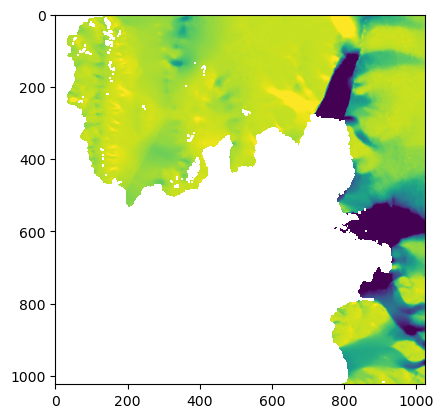

In [329]:
plt.imshow(velocity_multi_and_single.loc[1, 2009], cmap='viridis', vmin=-1000, vmax=100)

In [330]:
#Now we put the values of the single years where the multi year velocity is lacking

velocity_multi_and_single_2 = velocity_multi_and_single.copy()

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  < threshold_interpolation:

            mask_nan = np.isnan(velocity_multi_and_single.loc[id, year]) # This is the mask where in the low coverage we have nan values
            mask_not_a_nan_in_single_year = ~np.isnan(velocity_x_tif_smoothed.loc[id, year]) #
            combined_mask = np.logical_and(mask_nan, mask_not_a_nan_in_single_year)

            velocity_multi_and_single_2.loc[id, year][combined_mask] = velocity_x_tif_smoothed.loc[id, year][combined_mask]


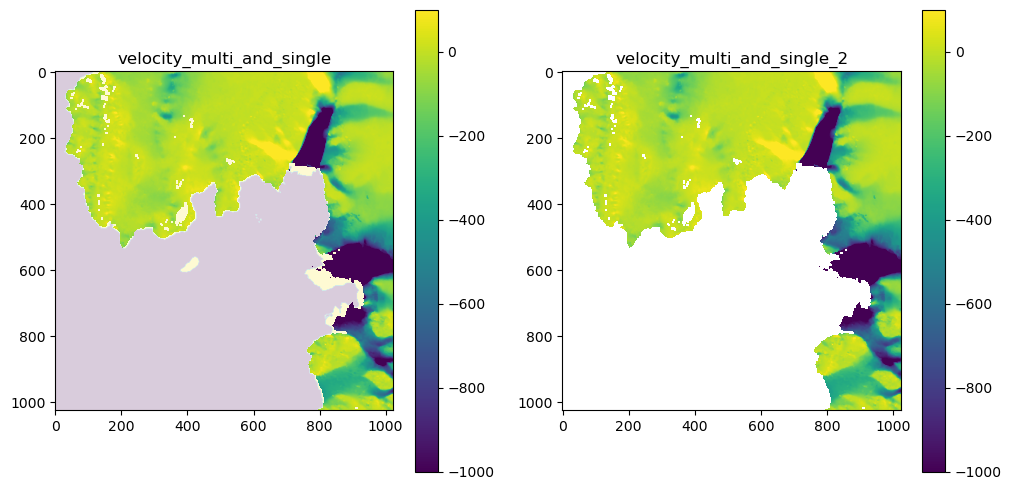

In [334]:
year = 2012

figs, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(velocity_multi_and_single.loc[1, year], cmap='viridis', vmin=-1000, vmax=100, alpha=0.7)
axes[0].imshow(~sea_mask.loc[1, year], cmap='viridis', alpha=0.2)
axes[0].set_title('velocity_multi_and_single')
#add colorbar
cbar = plt.colorbar(axes[0].imshow(velocity_multi_and_single.loc[1, year], cmap='viridis', vmin=-1000, vmax=100), ax=axes[0])

axes[1].imshow(velocity_multi_and_single_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100)
axes[1].set_title('velocity_multi_and_single_2')
#add colorbar
cbar = plt.colorbar(axes[1].imshow(velocity_multi_and_single_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100), ax=axes[1])

In [335]:
coverage_no_nan_v_x_grounded

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.457929,0.325308,0.719449,0.791665,0.576205,0.710896,0.478989,0.275146,0.913964,0.947315,0.767209,0.925112


Here i will check possibilities for thwaites and Pine Island

In [120]:
board = boarders_mask.loc[1, 2008]
ice = ice_mask.loc[1, 2008]

board_ice = np.logical_and(board, ice)


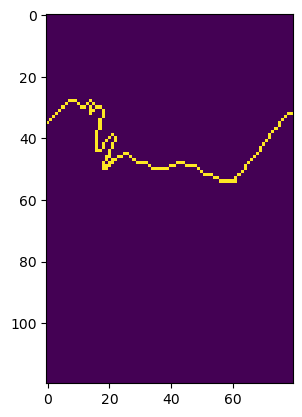

In [121]:
plt.imshow(board_ice[280:400,710:790], cmap='viridis')

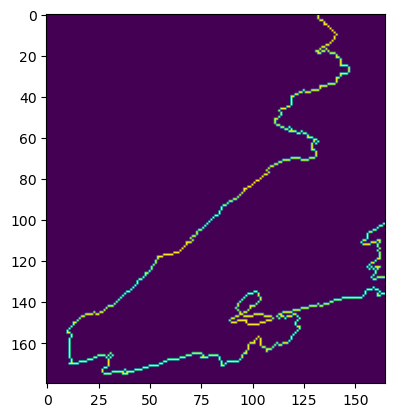

In [122]:
plt.imshow(board_ice[550:730,660:825], cmap='viridis')

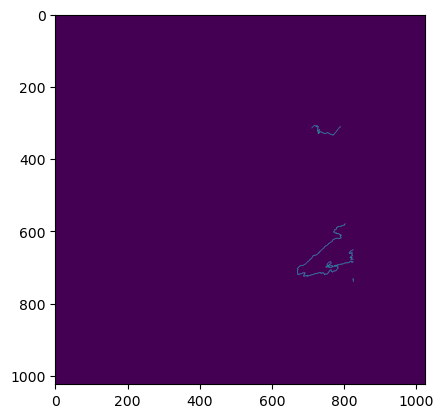

In [123]:
# Define the slices for the regions of interest
region1_slice = (slice(280, 401), slice(710, 791))
region2_slice = (slice(580, 741), slice(660,826))

result_mask = np.full_like(board_ice, fill_value=False)

# Extract the regions using the slices
result_mask[region1_slice] = board_ice[region1_slice]
result_mask[region2_slice] = board_ice[region2_slice]

plt.imshow(result_mask, cmap='viridis')


In [136]:
green_and_multi = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    #To chenge in velocity_multy_years_x.loc[id, 'image']==0 if it has not been set to nan
    mask_x_0_in_multi_year = np.isnan(velocity_multy_years_x.loc[id, 'image'])

    for year in common_years:

            #check when velocity_multy_years_x.loc[id, 'image'][ice_mask.loc[id, year]] is 0
            #velocity_01_x.loc[id, year][ice_mask.loc[id, year]] = 0
            green_and_multi.loc[id,year] = np.logical_and(mask_x_0_in_multi_year, ice_mask.loc[id, year])

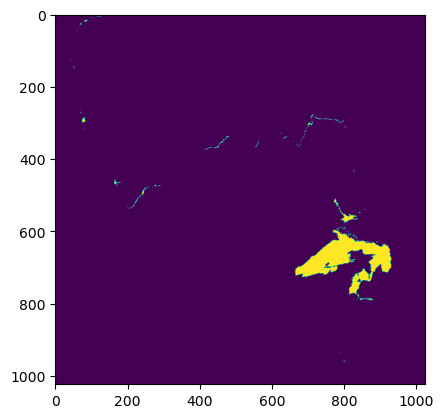

In [139]:
plt.imshow(green_and_multi.loc[1,2009], cmap='viridis')

In [140]:
#Cooking Thwaites and PI
from scipy import ndimage

# Define the slices for the regions of interest
region1_slice = (slice(280, 401), slice(710, 791))
region2_slice = (slice(580, 741), slice(660,826))

result_mask = np.full_like(board_ice, fill_value=False)

# Extract the regions using the slices
result_mask[region1_slice] = board_ice[region1_slice]
result_mask[region2_slice] = board_ice[region2_slice]

pine_island_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)

interpo_th = []

pine_island_boarder = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we look at the average velocity in the boarders of the two regions, usign the year velcoiuty dataset
        pine_island_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region1_slice])
        thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])

        interpo_th.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))

        #Here we load the boarders
        board = boarders_mask.loc[id, year]
        ice = ice_mask.loc[id, year]

        #where we have both ice and boarders
        ice_board = np.logical_and(board, ice)

        #creating background for PI and Th
        back_ground_pi = np.full_like(ice, fill_value=False)
        back_ground_th = np.full_like(ice, fill_value=False)

        #The slices for the regions of interest
        back_ground_pi[region1_slice] = ice_board[region1_slice]
        back_ground_th[region2_slice] = ice_board[region2_slice]

        #Expand the boarders of 10 pixels
        #back_ground_pi = ndimage.binary_dilation(back_ground_pi, iterations=iterations)
        #back_ground_th = ndimage.binary_dilation(back_ground_th, iterations=iterations)

        #saving the boarders
        pine_island_boarder.loc[id, year] = back_ground_pi
        thwaites_boarders.loc[id, year] = back_ground_th


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_12616/3073031750.py:29: RuntimeWarning: Mean of empty slice
  thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_12616/3073031750.py:31: RuntimeWarning: Mean of empty slice
  interpo_th.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))


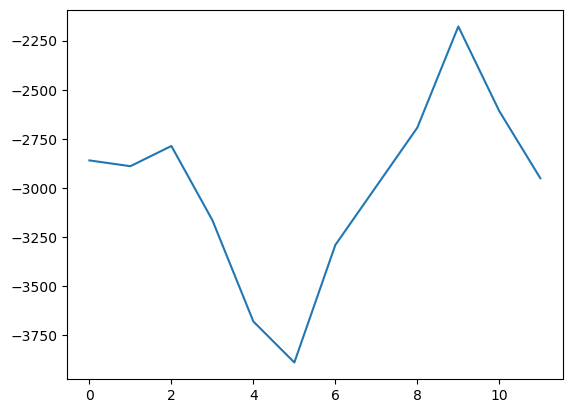

In [454]:
#inteprolate interpo_th

interpo_th
interpo_th = np.array(interpo_th)
interpo_th = interpolation_excluding_extreames(interpo_th)

plt.plot(interpo_th)

In [425]:
#Interpolation for
v_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        prova = velocity_multi_and_single_2.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_x.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_x_final.loc[id, year] = prova 

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


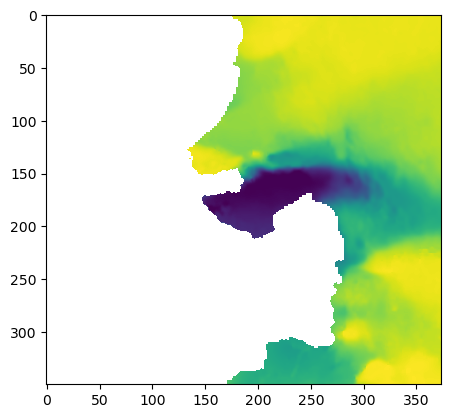

In [456]:
plt.imshow(v_x_final.loc[1,2015][400:750, 650:1500], cmap='viridis')

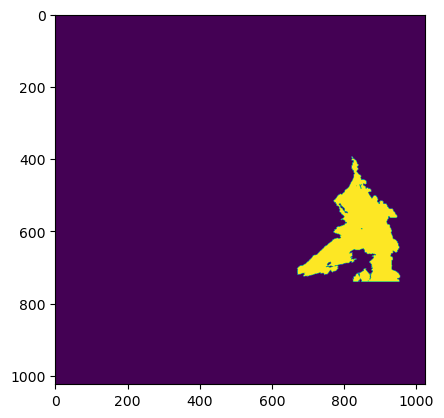

In [457]:
# Here I am looking at Thwaites 

region_th = (slice(380, 741), slice(600, 1001)) #Thwaites

mask_th = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        result_mask = np.full_like(ice_mask.loc[id,year], fill_value=False)
        result_mask[region_th] = ice_mask.loc[id,year][region_th]
        mask_th.loc[id, year] = result_mask

        #mask_th.loc[id, year] = thwaites_boarders.loc[id, year]

plt.imshow(mask_th.loc[1,2008], cmap='viridis')

In [495]:
#Specifical for Thwaites 2011 and 2012

v_x_final_2 = pd.DataFrame(index = df.index, columns = common_years)

i = 0
for year in [2011,2012,2013]:
    
    prova = v_x_final.loc[1, year]
    prova[green_and_multi.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = velocity_x_tif_smoothed.loc[id, year][mask_th.loc[id, year]]
    prova[thwaites_boarders.loc[id,year]] = interpo_th[i]

    mask_nan = np.isnan(prova)
    prova = inpaint.inpaint_biharmonic(prova, mask_nan)
    prova[sea_mask.loc[id, year]] = np.nan

    v_x_final_2.loc[1, year] = prova

    i = i + 1


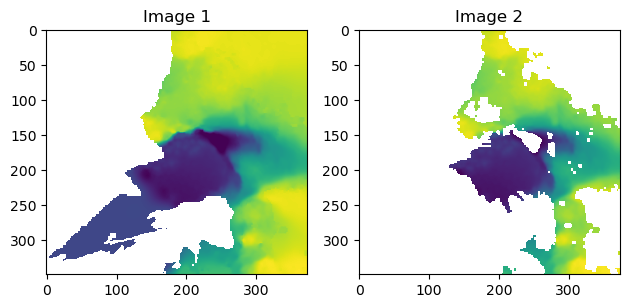

In [496]:

year = 2011
plt.subplot(1, 2, 1)
# Plot the first image
plt.imshow(v_x_final_2.loc[1, year][400:750, 650:1500], cmap='viridis')
plt.title('Image 1')
#cbar = plt.colorbar()

# Create the second subplot
plt.subplot(1, 2, 2)
# Plot the second image
plt.imshow(velocity_x_tif_smoothed.loc[1, year][400:750, 650:1500], cmap='viridis',)
#plt.imshow(thwaites_boarders.loc[1, year][400:750, 650:1500], cmap='viridis',alpha = 0.3)
plt.title('Image 2')

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()



In [497]:
v_x_final_3 = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        v_x_final_3.loc[id, year] = v_x_final.loc[id, year]

        print(np.shape(v_x_final_3.loc[id, year]))

        if year == 2011 or year == 2012:
            v_x_final_3.loc[id, year] = v_x_final_2.loc[id, year]
   

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


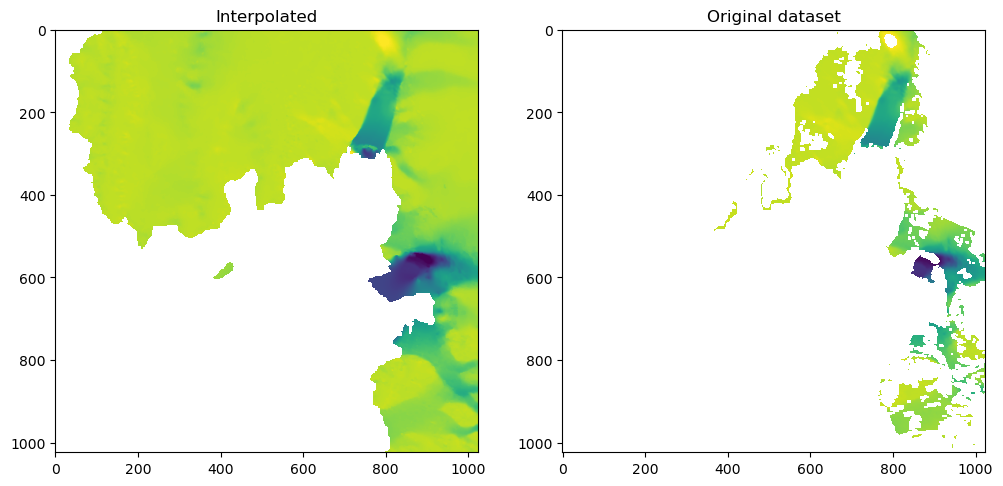

In [498]:
year = 2012

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(v_x_final_3.loc[1, year], cmap='viridis')
axes[0].set_title('Interpolated')

# Plot the second image
axes[1].imshow(velocity_x_tif_smoothed.loc[1, year], cmap='viridis')
axes[1].set_title('Original dataset')

plt.show()


Now I will look at Pine Island

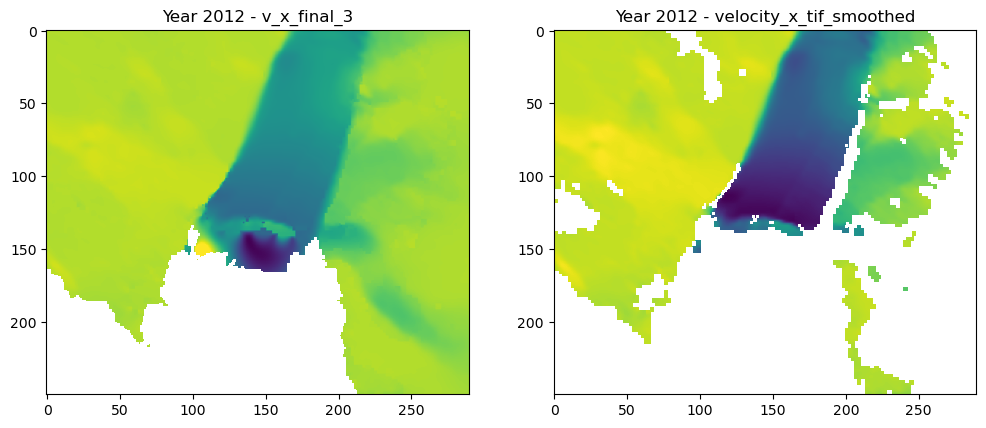

In [500]:
import matplotlib.pyplot as plt

year = 2012
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(v_x_final_3.loc[1, year][150:400, 610:900], cmap='viridis')
#Add colorbar
#cbar = plt.colorbar(axes[0].imshow(v_x_final_3.loc[1, year][150:400, 610:800], cmap='viridis', vmin = -1000, vmax = 100), ax=axes[0])
#cbar.set_label('Velocity (m/yr)')
axes[0].set_title(f'Year {year} - v_x_final_3')

# Plot the second image with some transparency (alpha parameter)
axes[1].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:900], cmap='viridis')
#Add colorbar
#cbar = plt.colorbar(axes[1].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:800], cmap='viridis', alpha=0.7, vmin = -1000, vmax = 100), ax=axes[1])
#cbar.set_label('Velocity (m/yr)')
axes[1].set_title(f'Year {year} - velocity_x_tif_smoothed')

plt.show()


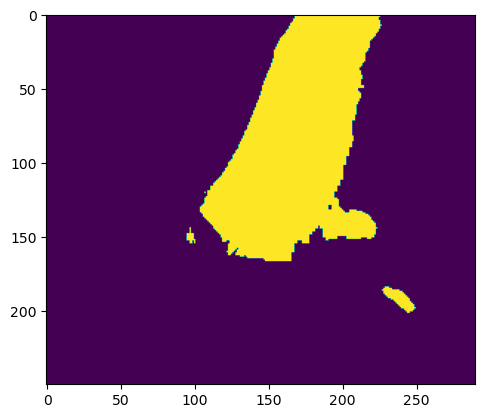

In [501]:
year = 2012

percentile_20 = np.nanpercentile(v_x_final_3.loc[1, year][150:400, 610:900], 22)

low_values_flags = v_x_final_3.loc[id,year][150:400, 610:900] < percentile_20  # Where values are low
plt.imshow(low_values_flags, cmap='viridis')

In [503]:
#Trying to solve P.I 

#pi_coords = [150:400, 610:900]

pi_region = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in [2011,2012,2013]:

        prova = v_x_final_3.loc[id, year][150:400, 610:900]
        prova[green_and_multi.loc[id, year][150:400, 610:900]] = np.nan

        #floating_ice = ice_mask.loc[id, year][150:400, 610:900]
        percentile_20th = np.nanpercentile(prova, 20)

        percentile_region = prova < percentile_20th

        nan_in_the_single_year = np.isnan(velocity_x_tif_smoothed.loc[id, year][150:400, 610:900])

        combined_mask = np.logical_and(percentile_region, nan_in_the_single_year)
        

        prova[combined_mask] = np.nan

        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year][150:400, 610:900]] = np.nan

        pi_region.loc[id, year] = prova



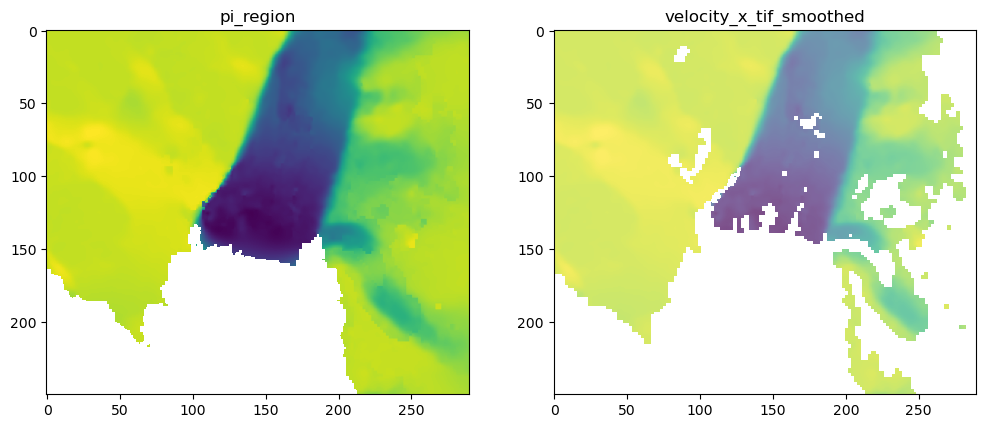

In [507]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

year = 2011

# Plot the first image
axes[0].imshow(pi_region.loc[1, year], cmap='viridis')
axes[0].set_title('pi_region')

# Plot the second image with some transparency (alpha parameter)
axes[1].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:900], cmap='viridis', alpha=0.7)
axes[1].set_title('velocity_x_tif_smoothed')

plt.show()


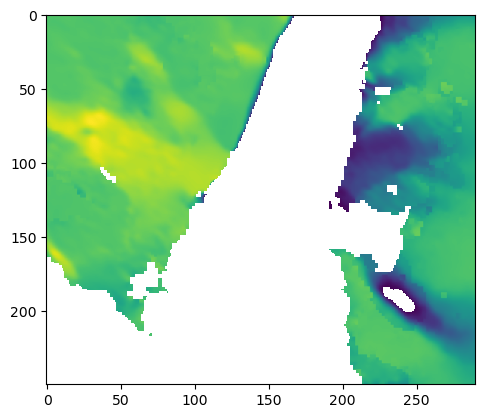

In [439]:
plt.imshow(v_x_final_3.loc[id, year][150:400, 610:900])

In [251]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Here i plot the images separated

# Specify the output PDF file
output_pdf_file = 'output_graphs_v-final_3.pdf'

# Create a PdfPages object to save the figures

with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year

    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(v_x_final_3.loc[1, year], vmin=-1000, vmax=100)
        axs[0, 0].set_title(f'Year: {year}\nFull Image')
        cbar = plt.colorbar(axs[0, 0].imshow(v_x_final_3.loc[1, year]), ax=axs[0, 0])

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(v_x_final_3.loc[1, year][400:750, 650:1500], vmin=-1000, vmax=100)
        axs[0, 1].set_title('Cropped Image 1')
        cbar = plt.colorbar(axs[0, 1].imshow(v_x_final_3.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(v_x_final_3.loc[1, year][100:450, 550:900], vmin=-1000, vmax=100)
        axs[1, 0].set_title('Cropped Image 2')
        cbar = plt.colorbar(axs[1, 0].imshow(v_x_final_3.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(v_x_final_3.loc[1, year][0:200, 0:200], vmin=-1000, vmax=100)
        axs[1, 1].set_title('Cropped Image 3')
        cbar = plt.colorbar(axs[1, 1].imshow(v_x_final_3.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

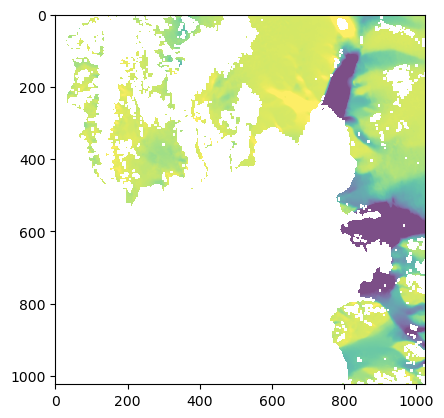

In [267]:
plt.imshow((velocity_x_tif_smoothed.loc[1, 2015]), cmap='viridis', vmin=-1000, vmax=100, alpha=0.7)

I will go step by step here

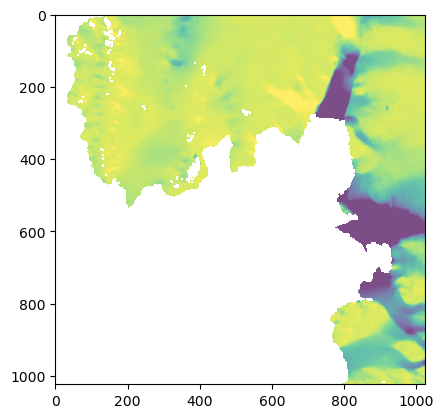

In [53]:
year = 2005
prova = velocity_multi_and_single_2.loc[1, year]
plt.imshow(prova, cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)



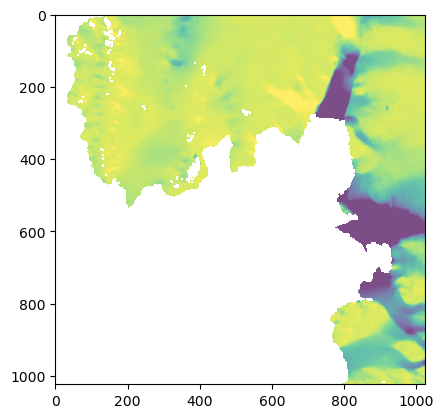

In [54]:
prova[green_and_multi.loc[1, year]] = np.nan
plt.imshow(prova, cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

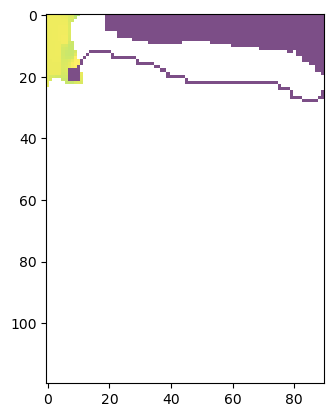

In [55]:
prova[thwaites_boarders.loc[1,year]] = thwaites_boarders_average_x.loc[1, year]
prova[pine_island_boarder.loc[1,year]] = pine_island_boarders_average_x.loc[1, year]

plt.imshow(prova[280:400,700:790], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

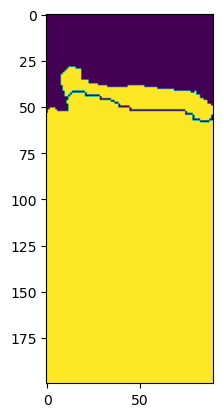

In [56]:
#mask of where is nan
mask_nan = np.isnan(prova)
plt.imshow(mask_nan[250:450,700:790], cmap='viridis')

In [57]:
#make the interpolation with inpaint
prova = inpaint.inpaint_biharmonic(prova, mask_nan)

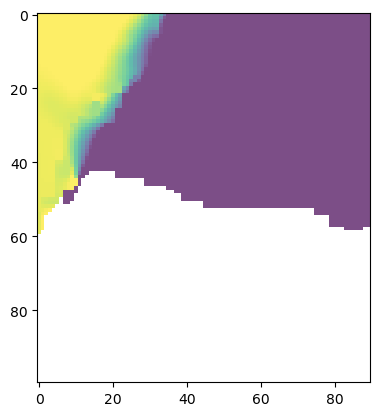

In [58]:
prova_2 = prova.copy()
prova_2[sea_mask.loc[1, year]] = np.nan
plt.imshow(prova_2[250:350,700:790], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

In [59]:
v_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
            
        prova = velocity_multi_and_single_2.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_x.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_x_final.loc[id, year] = prova 

KeyboardInterrupt: 

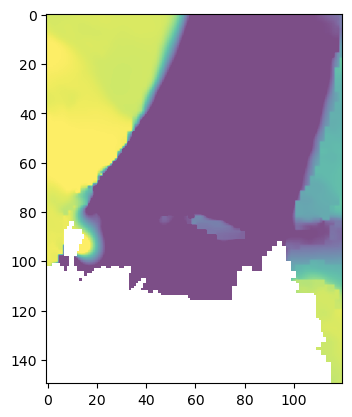

In [ ]:
plt.imshow(v_x_final.loc[1, 2012][200:350,700:820], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

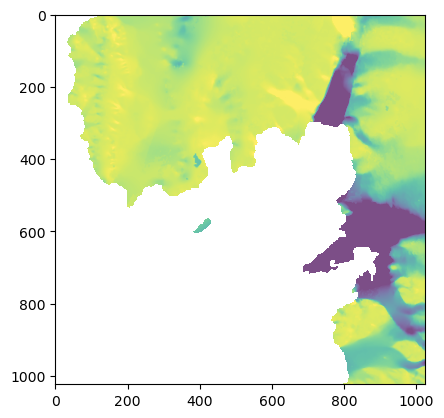

In [ ]:
for year in [2011,2012]:
    mask = 


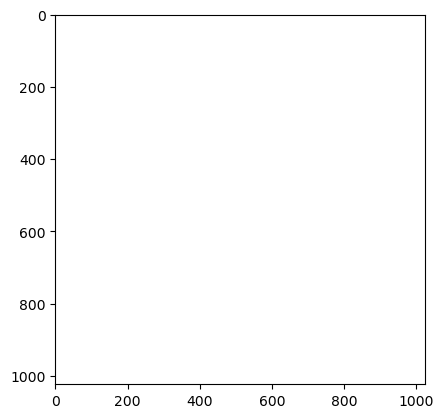

In [ ]:
#plt.imshow(velocity_multy_years_x.loc[1, 'image'][500:800,600:900], cmap='viridis', vmin=-1000, vmax=100, alpha=0.3)
plt.imshow(ice_mask.loc[1, 2005], cmap='viridis', alpha=0)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Assuming velocity_x_tif_grounded_interpolated is a DataFrame with appropriate structure

# Specify the output PDF file
output_pdf_file = 'output_graphs.pdf'


# Create a PdfPages object to save the figures
with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year
    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(v_x_final.loc[1, year], vmin=-1000, vmax=100)
        axs[0, 0].set_title(f'Year: {year}\nFull Image')
        cbar = plt.colorbar(axs[0, 0].imshow(v_x_final.loc[1, year]), ax=axs[0, 0])

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(v_x_final.loc[1, year][400:750, 650:1500], vmin=-1000, vmax=100)
        axs[0, 1].set_title('Cropped Image 1')
        cbar = plt.colorbar(axs[0, 1].imshow(v_x_final.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(v_x_final.loc[1, year][100:450, 550:900], vmin=-1000, vmax=100)
        axs[1, 0].set_title('Cropped Image 2')
        cbar = plt.colorbar(axs[1, 0].imshow(v_x_final.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(v_x_final.loc[1, year][0:200, 0:200], vmin=-1000, vmax=100)
        axs[1, 1].set_title('Cropped Image 3')
        cbar = plt.colorbar(axs[1, 1].imshow(v_x_final.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

2006
2007


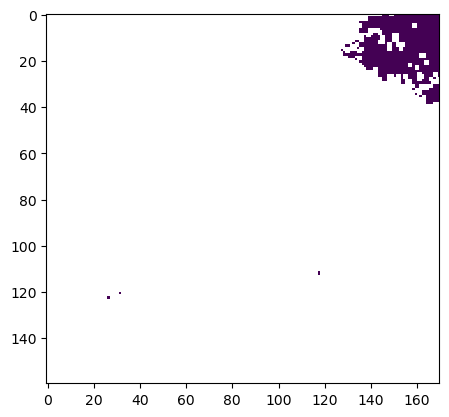

In [ ]:
#6 minuti per regione

velocity_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in [2006,2007]:

        velocity_x_final.loc[id,year] = velocity_multi_and_single_2.loc[id, year]

        print(year)
        velocity_x_final.loc[id,year][green_and_multi.loc[id,year]] = np.nan
        velocity_x_final.loc[id,year][sea_mask.loc[id,year]] = np.nan

        #here i neet to fill the Thwaites and the Pine Island
        velocity_x_final.loc[id,year][thwaites_boarders.loc[id, year]] = thwaites_boarders_average_x.loc[id, year]
        velocity_x_final.loc[id,year][pine_island_boarder.loc[id, year]] = pine_island_boarders_average_x.loc[id, year]

        plt.imshow(velocity_x_final.loc[id, year][580:740,650:820], cmap='viridis', vmin=-1000, vmax=100)

        #make the interpolation
        mask_nan = np.isnan(velocity_x_final.loc[id, year])  

        velocity_x_final.loc[id,year] = inpaint.inpaint_biharmonic(velocity_x_final.loc[id, year], mask_nan)
        velocity_x_final.loc[id,year][sea_mask.loc[id,year]] = np.nan


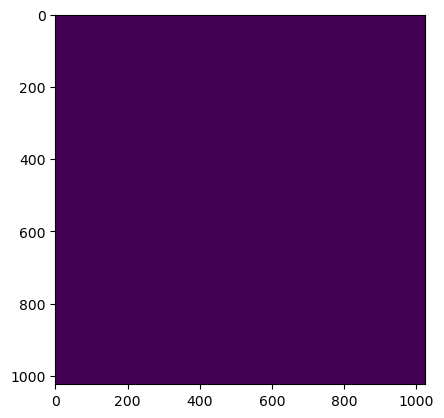

In [ ]:
plt.imshow(green_and_multi.loc[1, 2006])

In [ ]:
# Subplot 1: velocity_x_final
year = 2008
#[650:750, 650:800] Thwaites
prova = velocity_x_tif_smoothed.loc[1, year]
prova[pine_island_boarder.loc[1, year]] = pine_island_boarders_average_x.loc[1, year]

plt.subplot(1, 2, 1)
plt.imshow(velocity_multi_and_single_2.loc[id, year][250:400,680:820], cmap='viridis')
#plt.imshow(ice_mask.loc[id, year][400:750, 650:1500], cmap='viridis', alpha=0.8)
plt.title('velocity_x_final')

# Subplot 2: velocity_x_tif_smoothed
plt.subplot(1, 2, 2)
plt.imshow(velocity_x_tif_smoothed.loc[1, year][300:400,700:820], cmap='viridis')
plt.title('velocity_x_tif_smoothed')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


: 

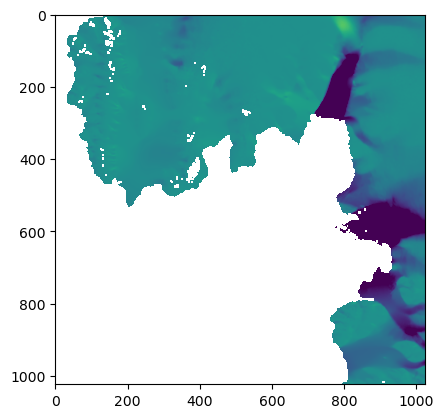

In [ ]:
plt.imshow(velocity_multy_years_x.loc[1, 'image'], cmap='viridis', vmin=-1000, vmax=1000)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Assuming velocity_x_tif_grounded_interpolated is a DataFrame with appropriate structure

# Specify the output PDF file
output_pdf_file = 'output_graphs.pdf'


# Create a PdfPages object to save the figures
with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year
    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(velocity_x_final.loc[1, year], vmin=-1000, vmax=100)
        axs[0, 0].set_title(f'Year: {year}\nFull Image')
        cbar = plt.colorbar(axs[0, 0].imshow(velocity_x_final.loc[1, year]), ax=axs[0, 0])

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(velocity_x_final.loc[1, year][400:750, 650:1500], vmin=-1000, vmax=100)
        axs[0, 1].set_title('Cropped Image 1')
        cbar = plt.colorbar(axs[0, 1].imshow(velocity_x_final.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(velocity_x_final.loc[1, year][100:450, 550:900], vmin=-1000, vmax=100)
        axs[1, 0].set_title('Cropped Image 2')
        cbar = plt.colorbar(axs[1, 0].imshow(velocity_x_final.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(velocity_x_final.loc[1, year][0:200, 0:200], vmin=-1000, vmax=100)
        axs[1, 1].set_title('Cropped Image 3')
        cbar = plt.colorbar(axs[1, 1].imshow(velocity_x_final.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Assuming velocity_x_tif_grounded_interpolated is a DataFrame with appropriate structure

# Specify the output PDF file
output_pdf_file = 'output_graphs.pdf'


# Create a PdfPages object to save the figures
with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year
    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(velocity_multi_and_single.loc[1, year], vmin=-1000, vmax=100)
        axs[0, 0].set_title(f'Year: {year}\nFull Image')
        cbar = plt.colorbar(axs[0, 0].imshow(velocity_multi_and_single.loc[1, year]), ax=axs[0, 0])

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(velocity_multi_and_single.loc[1, year][400:750, 650:1500], vmin=-1000, vmax=100)
        axs[0, 1].set_title('Cropped Image 1')
        cbar = plt.colorbar(axs[0, 1].imshow(velocity_multi_and_single.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(velocity_multi_and_single.loc[1, year][100:450, 550:900], vmin=-1000, vmax=100)
        axs[1, 0].set_title('Cropped Image 2')
        cbar = plt.colorbar(axs[1, 0].imshow(velocity_multi_and_single.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(velocity_multi_and_single.loc[1, year][0:200, 0:200], vmin=-1000, vmax=100)
        axs[1, 1].set_title('Cropped Image 3')
        cbar = plt.colorbar(axs[1, 1].imshow(velocity_multi_and_single.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

In [ ]:
green_and_multi = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    mask_x_0_in_multi_year = velocity_multy_years_x.loc[id, 'image']==0

    for year in common_years:

            #check when velocity_multy_years_x.loc[id, 'image'][ice_mask.loc[id, year]] is 0
            #velocity_01_x.loc[id, year][ice_mask.loc[id, year]] = 0
            green_and_multi.loc[id,year] = np.logical_and(mask_x_0_in_multi_year, ice_mask.loc[id, year])

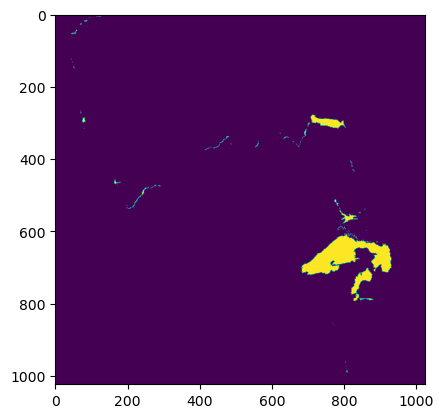

In [ ]:
plt.imshow(green_and_multi.loc[1,2006])

In [ ]:
for id in df.index:
    for year in common_years:

        print(year)
        velocity_x_tif_grounded_interpolated.loc[id,year][green_and_multi.loc[id,year]] = np.nan

        #make the inteprolation
        mask_nan = np.isnan(velocity_x_tif_grounded_interpolated.loc[id, year])
        velocity_x_tif_grounded_interpolated.loc[id,year] = inpaint.inpaint_biharmonic(velocity_x_tif_grounded_interpolated.loc[id, year], mask_nan)
        velocity_x_tif_grounded_interpolated.loc[id,year][sea_mask.loc[id,year]] = np.nan

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


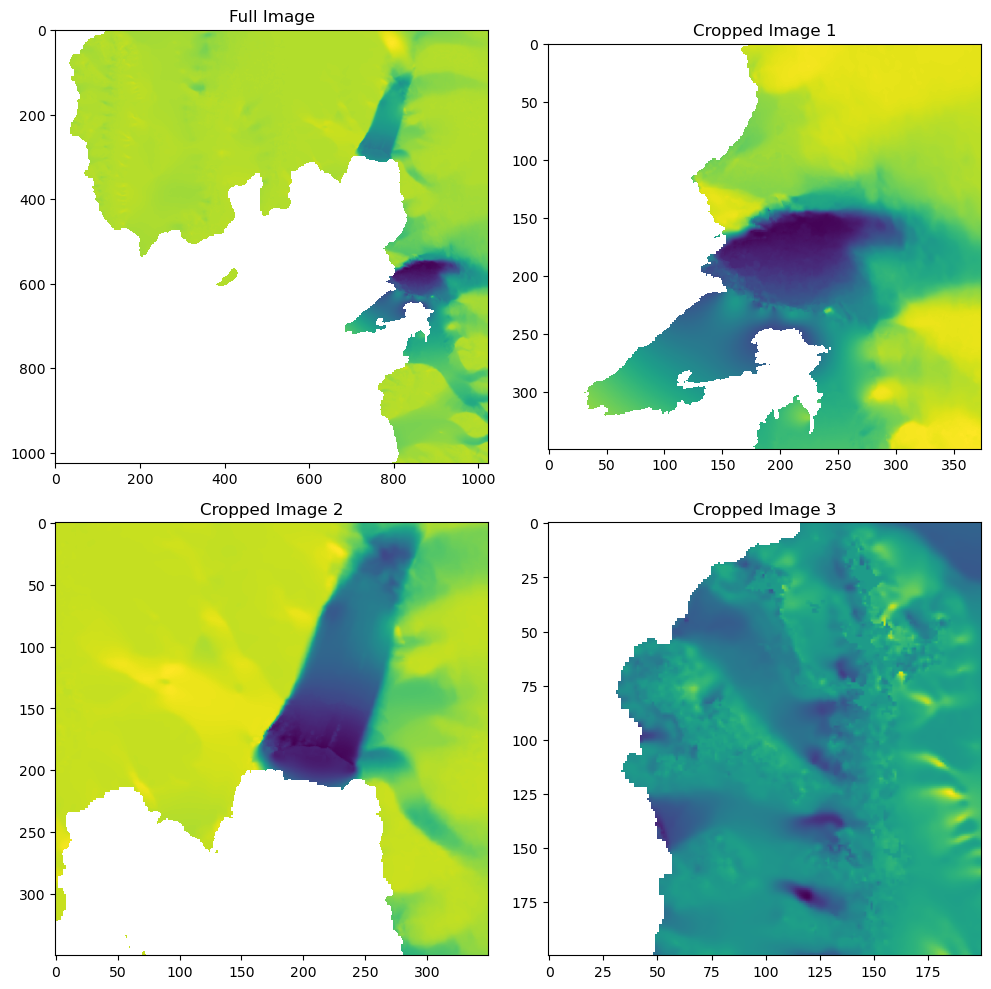

In [ ]:
year = 2006

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first image in the top-left subplot
axs[0, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year])
axs[0, 0].set_title('Full Image')

# Plot the second image in the top-right subplot
axs[0, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][400:750, 650:1500])
axs[0, 1].set_title('Cropped Image 1')

# Plot the third image in the bottom-left subplot
axs[1, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][100:450, 550:900])
axs[1, 0].set_title('Cropped Image 2')

# Plot the fourth image in the bottom-right subplot
axs[1, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][0:200, 0:200])
axs[1, 1].set_title('Cropped Image 3')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


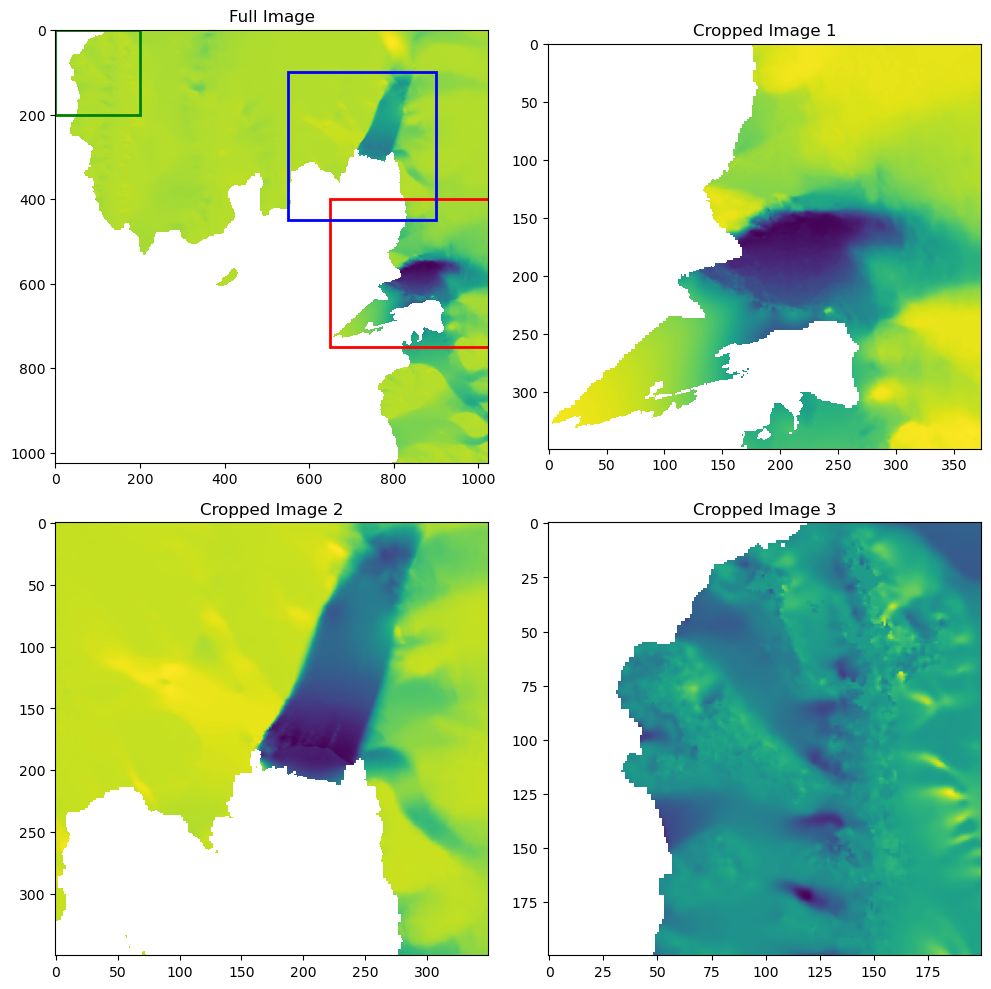

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

year = 2011

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first image in the top-left subplot
axs[0, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year])
axs[0, 0].set_title('Full Image')

# Plot the second image in the top-right subplot
axs[0, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][400:750, 650:1500])
axs[0, 1].set_title('Cropped Image 1')

# Plot the third image in the bottom-left subplot
axs[1, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][100:450, 550:900])
axs[1, 0].set_title('Cropped Image 2')

# Plot the fourth image in the bottom-right subplot
axs[1, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][0:200, 0:200])
axs[1, 1].set_title('Cropped Image 3')

# Draw rectangles on the first image
rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
axs[0, 0].add_patch(rect_1)

rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
axs[0, 0].add_patch(rect_2)

rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
axs[0, 0].add_patch(rect_3)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Assuming velocity_x_tif_grounded_interpolated is a DataFrame with appropriate structure

# Specify the output PDF file
output_pdf_file = 'output_graphs.pdf'


# Create a PdfPages object to save the figures
with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year
    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year])
        axs[0, 0].set_title(f'Year: {year}\nFull Image')

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][400:750, 650:1500])
        axs[0, 1].set_title('Cropped Image 1')

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][100:450, 550:900])
        axs[1, 0].set_title('Cropped Image 2')

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][0:200, 0:200])
        axs[1, 1].set_title('Cropped Image 3')

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

# The PDF file will be saved with the specified filename (output_pdf_file)


In [ ]:
#smooth the velocity
from silx.image.medianfilter import medfilt2d

for id in df.index:
    for year in common_years:
        velocity_x_tif_grounded_interpolated.loc[id, year] = medfilt2d(velocity_x_tif_grounded_interpolated.loc[id, year], kernel_size=5)
        velocity_x_tif_grounded_interpolated.loc[id, year][sea_mask.loc[id, year]] = np.nan


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Assuming velocity_x_tif_grounded_interpolated is a DataFrame with appropriate structure

# Specify the output PDF file
output_pdf_file = 'output_graphs.pdf'


# Create a PdfPages object to save the figures
with PdfPages(output_pdf_file) as pdf:
    # Iterate over each year
    for year in range(common_years[0], common_years[-1] + 1):  # replace start_year and end_year with your desired range
        # Create a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot the first image in the top-left subplot
        axs[0, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year])
        axs[0, 0].set_title(f'Year: {year}\nFull Image')

        # Plot the second image in the top-right subplot
        axs[0, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][400:750, 650:1500])
        axs[0, 1].set_title('Cropped Image 1')

        # Plot the third image in the bottom-left subplot
        axs[1, 0].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][100:450, 550:900])
        axs[1, 0].set_title('Cropped Image 2')

        # Plot the fourth image in the bottom-right subplot
        axs[1, 1].imshow(velocity_x_tif_grounded_interpolated.loc[1, year][0:200, 0:200])
        axs[1, 1].set_title('Cropped Image 3')

        # Draw rectangles on the first image
        rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
        axs[0, 0].add_patch(rect_1)

        rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
        axs[0, 0].add_patch(rect_2)

        rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, 0].add_patch(rect_3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig()

        # Close the figure
        plt.close()

# The PDF file will be saved with the specified filename (output_pdf_file)


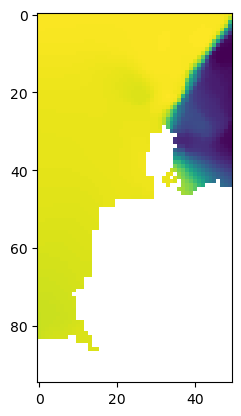

In [ ]:
plt.imshow(velocity_x_tif_grounded_interpolated.loc[1, 2011][255:350,680:730])

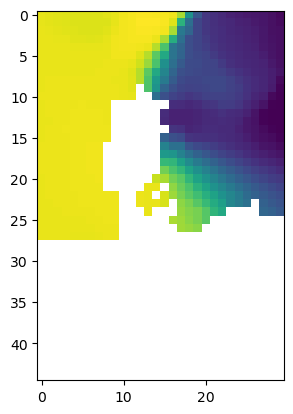

In [ ]:
plt.imshow(velocity_x_tif_grounded_interpolated.loc[1, 2011][275:320,700:730])

In [ ]:
rescaling_ratio_x #VERY SUSPICIOUS VALUE IN 2015

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,1.013516,1.067991,0,0,0.990622,0,1.338235,1.049568,0,0,0,0


In [ ]:
#now we look at the floating ice. (FOR NOW WE KEEP THE SMAE RATIO)  

NameError: name 'velocity_x_tif_grounded_floating_interpolated' is not defined

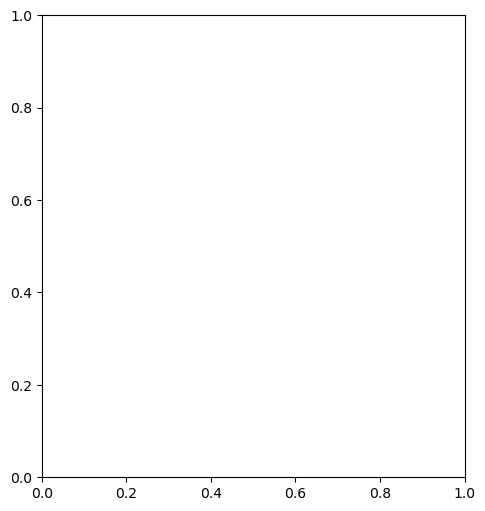

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

year = 2006

plt.imshow(velocity_x_tif_grounded_floating_interpolated.loc[1, year], cmap='viridis', alpha=0.7)
plt.title('Velocity X TIF')

plt.subplot(1, 2, 2)
plt.imshow(ice_mask.loc[1, year], cmap='viridis', alpha=0.7)
plt.title('Velocity Y TIF')

In [ ]:
#Now alculate the coverage ratio for each region. 
#HERE IS ON THE WHOLE ICE

# coverage_no_nan_v_x = pd.DataFrame(index = df.index, columns = common_years)
# coverage_no_nan_v_y = pd.DataFrame(index = df.index, columns = common_years)

# for id in df.index:
#     for year in common_years:

#         #This takes the number of the NOT A NAN nan pixels in the region which is not sea,
#         #divided by the total number of pixels which are not sea.
#         coverage_no_nan_v_x.loc[id, year] = np.sum(~np.isnan(velocity_x_tif.loc[id, year][~sea_mask.loc[id,year]])) / np.sum(~sea_mask.loc[id,year])
#         coverage_no_nan_v_y.loc[id, year] = np.sum(~np.isnan(velocity_y_tif.loc[id, year][~sea_mask.loc[id,year]])) / np.sum(~sea_mask.loc[id,year])



In [ ]:
coverage_no_nan_v_x

NameError: name 'coverage_no_nan_v_x' is not defined

Here i calculate the rescaling ratio:
- If coverage < 0.3 : take multi year without rescaling
- If 0.3 < coverage < 0.75: rescale the multi year
- If coverage > 0.75 interpolate

In [ ]:
thresold_1 = 0.3
thresold_2 = 0.75

In [ ]:
#calculate the rescaling ratio for X

rescaling_ratio_x = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #When we have less than thresold_1 coverage, we set the rescaling ratio to 1, because here we will take the multi year velocity
        if coverage_no_nan_v_x.loc[id,year] < thresold_1:
            rescaling_ratio_x.loc[id,year] = 1.0

        #When we have more than thresold_1 coverage, we calculate the rescaling ratio
        if coverage_no_nan_v_x.loc[id,year] >= thresold_1 and coverage_no_nan_v_x.loc[id,year] < thresold_2:
            mask_no_nan = ~np.isnan(velocity_x_tif.loc[id, year])
            mean_yearly_x = np.mean(velocity_x_tif.loc[id, year][mask_no_nan])
            mean_multi_year_x = np.mean(velocity_multy_years_x.loc[id, 'image'][mask_no_nan])
            rescaling_ratio_x.loc[id,year] = mean_yearly_x/mean_multi_year_x

        #When we have more than thresold_2 coverage, we set the rescaling ratio to 0, because here we will interpolate
        if coverage_no_nan_v_x.loc[id,year] >= thresold_2:
            rescaling_ratio_x.loc[id,year] = 0

    

NameError: name 'coverage_no_nan_v_x' is not defined

In [ ]:
#calculating the rescalinng ratio for Y

rescaling_ratio_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_y.loc[id,year] <thresold_1:
            rescaling_ratio_y.loc[id,year] = 1.0

        if coverage_no_nan_v_y.loc[id,year] >= thresold_1 and coverage_no_nan_v_y.loc[id,year] < thresold_2:
            
            mask_no_nan = ~np.isnan(velocity_y_tif.loc[id, year])

            mean_yearly_y = np.mean(velocity_y_tif.loc[id, year][mask_no_nan])
            mean_multi_year_y = np.mean(velocity_multy_years_y.loc[id, 'image'][mask_no_nan])

            rescaling_ratio_y.loc[id,year] = mean_multi_year_y / mean_yearly_y

        if coverage_no_nan_v_y.loc[id,year] >= thresold_2:
            rescaling_ratio_y.loc[id,year] = 0

Now we make the interpolation/rescaling

In [ ]:
from skimage.restoration import inpaint

velocity_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if rescaling_ratio_x.loc[id,year] == 1.0: #We take the multi year velocity
            velocity_x_final.loc[id,year] = velocity_multy_years_x.loc[id, 'image']

        if rescaling_ratio_x.loc[id,year] == 0: #We interpolate
            mask_nan = np.isnan(velocity_x_tif.loc[id, year])
            velocity_x_final.loc[id,year] = inpaint.inpaint_biharmonic(velocity_x_tif.loc[id, year], mask_nan)
            
            #set to 0 all the sea values
            velocity_x_final.loc[id,year][sea_mask.loc[id,year]] = 0
        
        else: #We rescale
            velocity_x_final.loc[id,year] = velocity_multy_years_x.loc[id, 'image'] * rescaling_ratio_x.loc[id,year]



In [ ]:
#Doing the same for Y
velocity_y_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if rescaling_ratio_y.loc[id,year] == 1.0: #We take the multi year velocity
            velocity_y_final.loc[id,year] = velocity_multy_years_y.loc[id, 'image']

        if rescaling_ratio_y.loc[id,year] == 0: #We interpolate
            mask_nan = np.isnan(velocity_y_tif.loc[id, year])
            velocity_y_final.loc[id,year] = inpaint.inpaint_biharmonic(velocity_y_tif.loc[id, year], mask_nan)
            
            #set to 0 all the sea values
            velocity_y_final.loc[id,year][sea_mask.loc[id,year]] = 0
        
        else: #We rescale
            velocity_y_final.loc[id,year] = velocity_multy_years_y.loc[id, 'image'] * rescaling_ratio_y.loc[id,year]

In [ ]:
rescaling_ratio_x

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.990138,1.023024,1.002894,0,1.109141,1.1444,1.094915,1.0,0,0,0,0


In [ ]:
coverage_no_nan_v_x

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.45992,0.327018,0.721545,0.793846,0.578346,0.713055,0.481176,0.277485,0.916148,0.949426,0.769512,0.927276


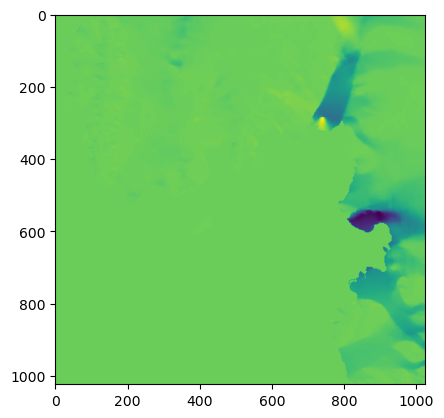

In [ ]:
plt.imshow(velocity_x_final.loc[1, 2013])

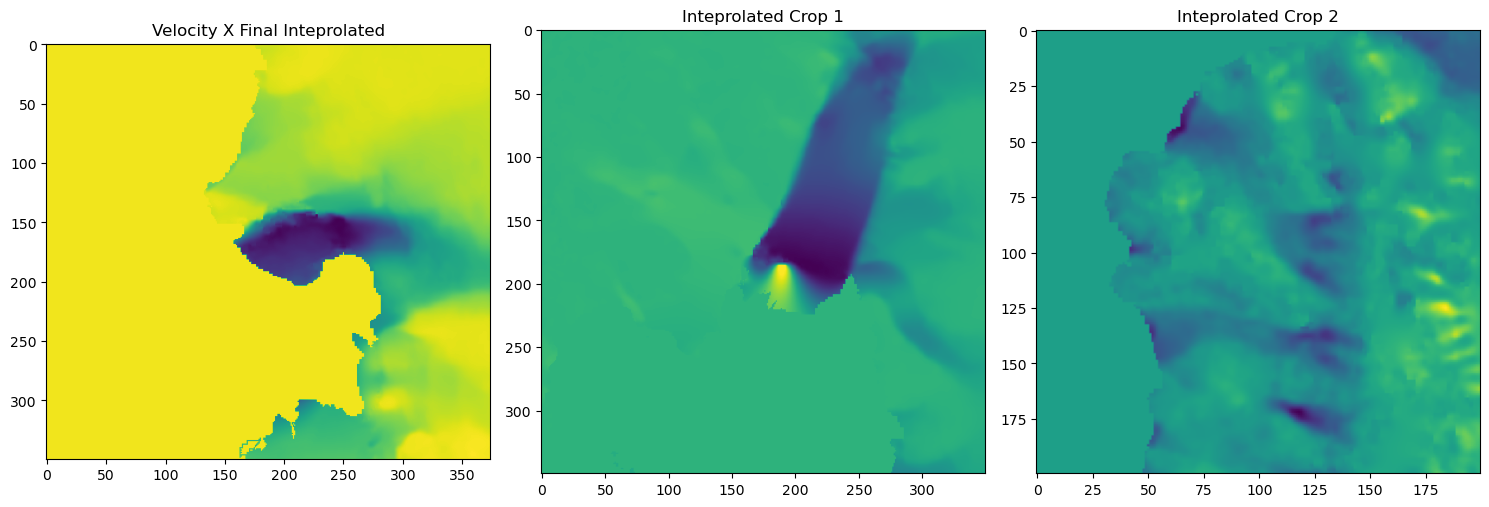

In [ ]:
prova = velocity_x_final.loc[1, 2013]

# Create a 1x3 subplot grid
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)
plt.imshow(prova[400:750,650:1500], cmap='viridis')
plt.title('Velocity X Final Inteprolated')

# Plot the second image
plt.subplot(1, 3, 2)
plt.imshow(prova[100:450, 550:900], cmap='viridis')
plt.title('Inteprolated Crop 1')

# Plot the third image
plt.subplot(1, 3, 3)
plt.imshow(prova[0:200, 0:200], cmap='viridis')
plt.title('Inteprolated Crop 2')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


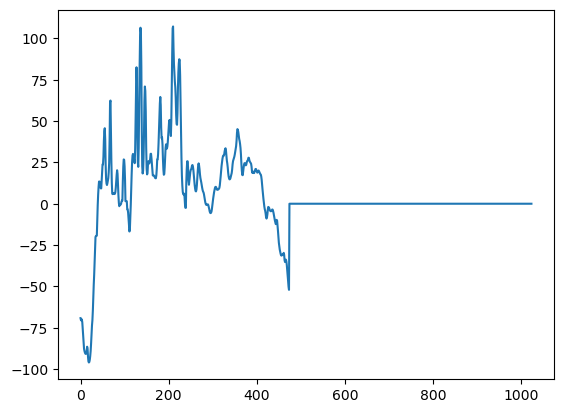

In [ ]:
plt.plot(prova[:,190])

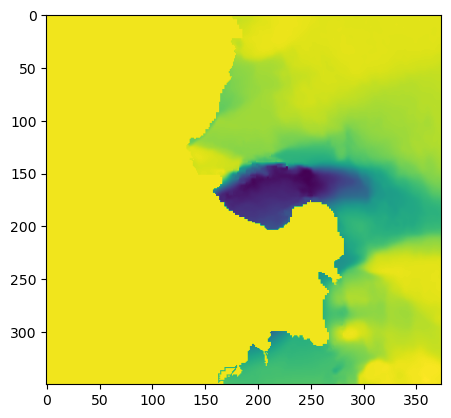

In [ ]:
prova = velocity_x_final.loc[1, 2013]
#prova[sea_mask.loc[1,2006]] = np.nan

plt.imshow(prova[400:750,650:1500], cmap = 'viridis')

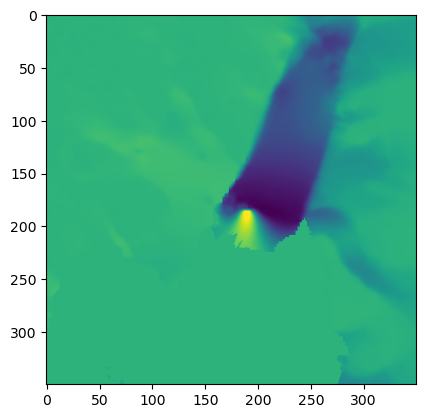

In [ ]:
plt.imshow(prova[100:450,550:900], cmap = 'viridis')

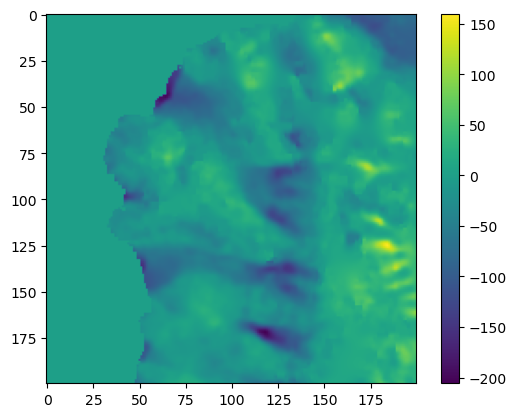

In [ ]:
plt.imshow(prova[0:200,0:200], cmap = 'viridis')

#add colorbar
plt.colorbar()

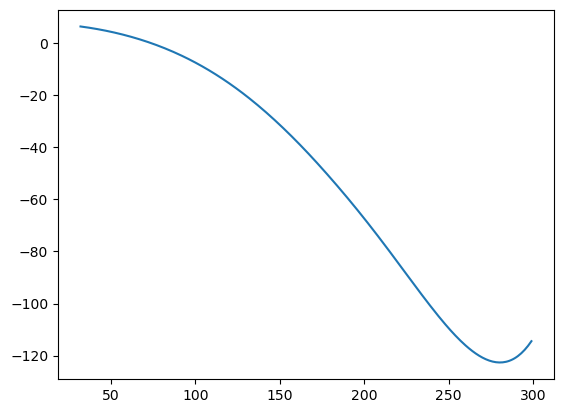

In [ ]:
#mae an interpolation of the velocity with inpaint methods
plt.plot(prova[75,0:300])

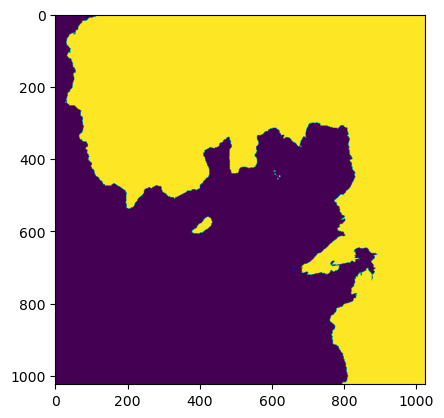

In [ ]:
plt.imshow(land_mask.loc[1, 2006] | ice_mask.loc[1,2006] | grounded_ice_mask.loc[1,2006], cmap='viridis')

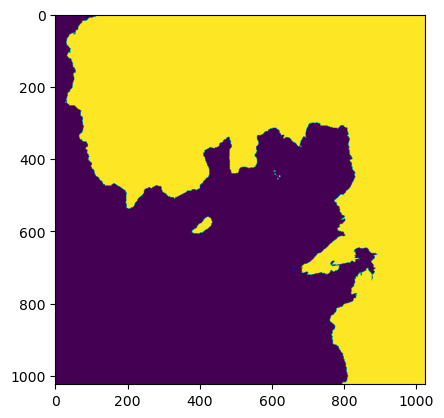

In [ ]:
plt.imshow(~sea_mask.loc[1,2006], cmap='viridis')

In [ ]:
#count the number of true pixels which are in the immage sea_mask.loc[1,2006]

np.sum(sea_mask.loc[1,2006])

511578

Count the ratio of the pixels which are not nan over the ~sea mask

In [ ]:
ratio_no_nan_v_x = pd.DataFrame(index = df.index, columns = common_years)
ratio_no_nan_v_y = pd.DataFrame(index = df.index, columns = common_years)

for